## 모든 팔렛트에 대해 prophet 라이브러리로 예측하고 그래프로 나타내었습니다. 

구체적인 코드 설명은 생략합니다.

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

In [3]:
from _element import feature_control as ft_c
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

In [7]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withallobj.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(path_name+varr.DF_DIR, INPUT_FILENAME)
df_temp= ft_c.xlsx_opener(path_name+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [9]:
y_col= df_raw['raw'].columns.values.tolist()

In [10]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [11]:
x_col= df_temp['raw'].columns.values.tolist()

In [12]:
df_raw['raw']['ds']= pd.to_datetime(df_raw['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_temp['raw']['ds']= pd.to_datetime(df_temp['raw']['ds'], box=True, format= '%Y/%m/%d', exact=True)
df_raw['raw']= pd.merge(df_raw['raw'], df_temp['raw'], how='inner', on='ds')

* 요일을 나누어 평일과 토요일, 일요일로 나누었습니다.

In [13]:
ft_c.add_division(df_raw, 'raw', 7, start_num= 3)

In [14]:
df_raw['raw']['seasonality_7,3']= df_raw['raw']['seasonality_7,3'].replace(to_replace= [0,1,2,3,4,5,6], value= ['mon','tue','wed','thu','fri','sat','sun'])

In [15]:
ft_c.divide_by(df_raw, 'raw', 'seasonality_7,3', div_set= {('mon','tue','wed','thu','fri'), ('sat',), ('sun',)})

In [16]:
for i in [('mon','tue','wed','thu','fri'),('sat', ),('sun', )]:
    ft_c.divide_multiple_y(df_raw, i, y_col, x_col, checkpoint= i)

In [17]:
df_raw

{"1025_('mon', 'tue', 'wed', 'thu', 'fri')":              ds   temp_max   temp_min  rain_amount    y
 0    2010-07-01  30.500000  24.900000          0.0    0
 1    2010-07-02  25.799999  22.700001         70.0  372
 4    2010-07-05  30.600000  21.799999          0.0   16
 5    2010-07-06  31.000000  22.400000          0.0  256
 6    2010-07-07  29.600000  21.900000          0.0   40
 7    2010-07-08  29.000000  21.299999          0.0   66
 8    2010-07-09  29.299999  21.799999          0.0  139
 11   2010-07-12  28.299999  22.200001          0.0   27
 12   2010-07-13  31.299999  21.900000          0.0   86
 13   2010-07-14  27.500000  22.700001          1.0  211
 14   2010-07-15  29.799999  24.299999          0.0    0
 15   2010-07-16  27.100000  21.700001         52.0  100
 18   2010-07-19  29.299999  24.200001          0.0   25
 19   2010-07-20  32.000000  26.700001          0.0   90
 20   2010-07-21  29.500000  26.000000          0.0  118
 21   2010-07-22  29.299999  24.500000      

In [ ]:
for i, case_df in df_raw.items():
    df_raw[i]= ft_c.train_test_sample(case_df, 'y', x_col, forecastday= varr.FORECASTDAY)

In [18]:
r= Result()

In [19]:
prpt_withobj= Prophet_timeseries(cv= False)

In [20]:
prpt_withobj.add_model('obj', 'day', regressor= False)

In [21]:
prpt_withobj.fit('obj', txs_traintest= df_raw)

KeyError: 'train'

In [22]:
prpt_withobj.forecast('obj', forecast_dict= r.forecast_dict)

KeyError: 'forecastProphetTable'

In [29]:
r.forecast_dict

OrderedDict([('_1041_merged',
              {'MAPE': nan,
               'MAPE_div_std': 74.513580691660607,
               'MAPE_with_std': 36.289764100273587,
               'RMSE': 1747.8579320642089,
               'forecast':           ds   temp_max   temp_min  rain_amount      y         yhat
               0 2017-02-17   4.800000  -7.200000          0.0   7731  8385.465452
               0 2017-02-18   2.100000  -6.200000          0.0   6970  8024.413849
               0 2017-02-19   5.000000  -0.400000          3.2      0     5.692780
               1 2017-02-20   0.600000  -6.400000          0.0   6482  6869.621962
               2 2017-02-21   4.900000  -4.600000          0.0   5250  7423.493738
               3 2017-02-22   3.400000  -3.100000          3.1   6997  7740.447484
               4 2017-02-23   1.600000  -5.700000          0.0   7140  7595.857154
               0 2017-04-28  20.700001   9.300000          0.0  10710  8086.477460
               0 2017-04-29  22.20000

In [24]:
r.merge_result(list(map(str, y_col)))
# list(map(str, y_col))

In [25]:
r.err_rate()

C:\Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Nextop\nextop-engine\nextop_engine\_element\calculations.py:13: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [26]:
r.print_err_rate()

RMSE with segment _1041_merged: 1747.8579
MAPE with segment _1041_merged: nan
MAPE_with_std with segment _1041_merged: 36.2898
MAPE_div_std with segment _1041_merged: 74.5136
sMAPE with segment _1041_merged: 22.4534


RMSE with segment _1057_merged: 443.6882
MAPE with segment _1057_merged: nan
MAPE_with_std with segment _1057_merged: 43.8860
MAPE_div_std with segment _1057_merged: 75.0808
sMAPE with segment _1057_merged: 46.5745


RMSE with segment _1091_merged: 248.4600
MAPE with segment _1091_merged: nan
MAPE_with_std with segment _1091_merged: 56.5466
MAPE_div_std with segment _1091_merged: 76.3932
sMAPE with segment _1091_merged: 76.8556


RMSE with segment _1117_merged: 3.4687
MAPE with segment _1117_merged: nan
MAPE_with_std with segment _1117_merged: 104.5571
MAPE_div_std with segment _1117_merged: 34.6567
sMAPE with segment _1117_merged: 200.0000


RMSE with segment _1261_merged: 722.8828
MAPE with segment _1261_merged: nan
MAPE_with_std with segment _1261_merged: 36.9782
MAPE_

In [27]:
prpt_withobj._model.keys()

dict_keys(['obj', "obj_1041_('mon', 'tue', 'wed', 'thu', 'fri')_0", "obj_1041_('mon', 'tue', 'wed', 'thu', 'fri')_1", "obj_1041_('mon', 'tue', 'wed', 'thu', 'fri')_2", "obj_1041_('mon', 'tue', 'wed', 'thu', 'fri')_3", "obj_1041_('mon', 'tue', 'wed', 'thu', 'fri')_4", "obj_1057_('mon', 'tue', 'wed', 'thu', 'fri')_0", "obj_1057_('mon', 'tue', 'wed', 'thu', 'fri')_1", "obj_1057_('mon', 'tue', 'wed', 'thu', 'fri')_2", "obj_1057_('mon', 'tue', 'wed', 'thu', 'fri')_3", "obj_1057_('mon', 'tue', 'wed', 'thu', 'fri')_4", "obj_1091_('mon', 'tue', 'wed', 'thu', 'fri')_0", "obj_1091_('mon', 'tue', 'wed', 'thu', 'fri')_1", "obj_1091_('mon', 'tue', 'wed', 'thu', 'fri')_2", "obj_1091_('mon', 'tue', 'wed', 'thu', 'fri')_3", "obj_1091_('mon', 'tue', 'wed', 'thu', 'fri')_4", "obj_1117_('mon', 'tue', 'wed', 'thu', 'fri')_0", "obj_1117_('mon', 'tue', 'wed', 'thu', 'fri')_1", "obj_1117_('mon', 'tue', 'wed', 'thu', 'fri')_2", "obj_1117_('mon', 'tue', 'wed', 'thu', 'fri')_3", "obj_1117_('mon', 'tue', 'wed', 

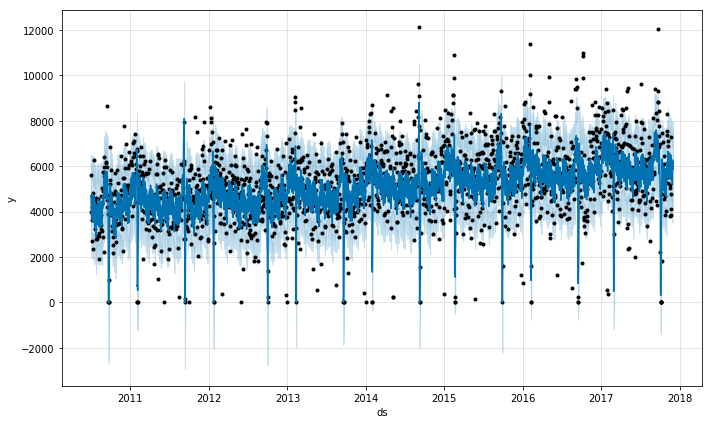

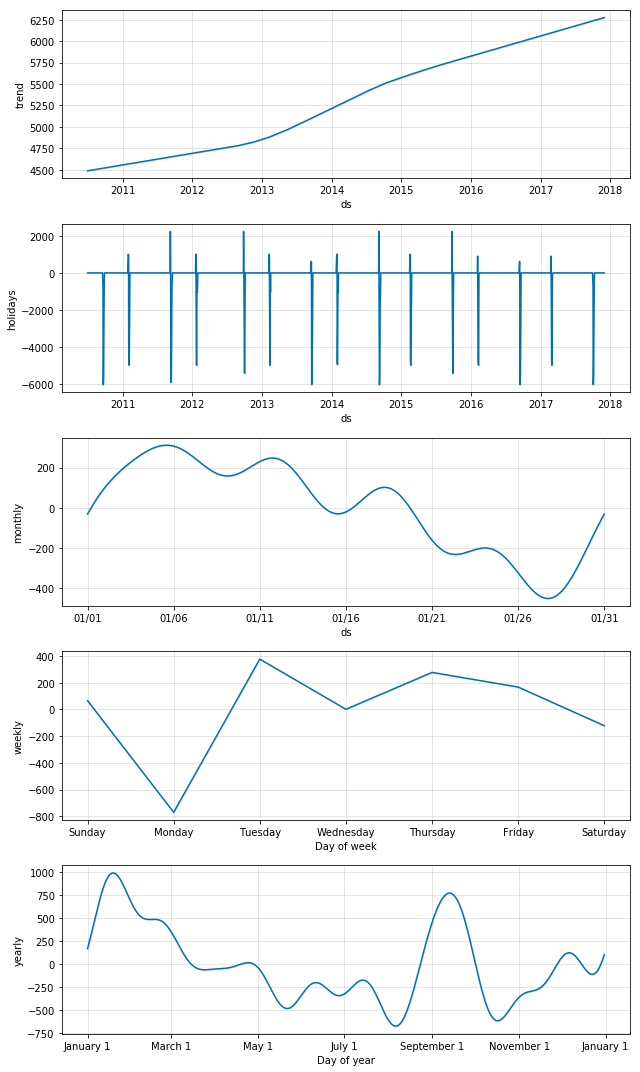

In [28]:
prpt_withobj.plot("obj_1878_('mon', 'tue', 'wed', 'thu', 'fri')_0")